<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Part 2 : Data Cleaning and Feature Engineering

---
## Data description
In this competition, you will be analyzing weather data and GIS data and predicting whether or not West Nile virus is present, for a given time, location, and species. 

**Every year from late-May to early-October, public health workers in Chicago setup mosquito traps scattered across the city. Every week from Monday through Wednesday, these traps collect mosquitos, and the mosquitos are tested for the presence of West Nile virus** before the end of the week. The test results include the number of mosquitos, the mosquitos species, and whether or not West Nile virus is present in the cohort. 

#### Main dataset
These test results are organized in such a way that when the number of mosquitos exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitos are capped at 50. 

The location of the traps are described by the block number and street name. For your convenience, we have mapped these attributes into Longitude and Latitude in the dataset. Please note that these are derived locations. For example, Block=79, and Street= "W FOSTER AVE" gives us an approximate address of "7900 W FOSTER AVE, Chicago, IL", which translates to (41.974089,-87.824812) on the map.

Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are postfixed with letters. For example, T220A is a satellite trap to T220. 

Please note that not all the locations are tested at all times. Also, records exist only when a particular species of mosquitos is found at a certain trap at a certain time. In the test set, we ask you for all combinations/permutations of possible predictions and are only scoring the observed ones.

#### Spray data
The City of Chicago also does spraying to kill mosquitos. You are given the GIS data for their spray efforts in 2011 and 2013. Spraying can reduce the number of mosquitos in the area, and therefore might eliminate the appearance of West Nile virus. 

![](https://storage.googleapis.com/kaggle-competitions/kaggle/4366/media/all_loc_trap.png)

#### Weather data
It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet. We provide you with the dataset from NOAA of the weather conditions of 2007 to 2014, during the months of the tests. 

Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

#### Map data
The map files `mapdata_copyright_openstreetmap_contributors.rds` and `mapdata_copyright_openstreetmap_contributors.txt` are from Open Streetmap and are primarily provided for use in visualizations (but you are allowed to use them in your models if you wish).

Here's an example using `mapdata_copyright_openstreetmap_contributors.rds`, and here's one using `mapdata_copyright_openstreetmap_contributors.txt`.

---
## Files descriptions

* `train.csv`, `test.csv`: the training and test set of the main dataset. The training set consists of data from 2007, 2009, 2011, and 2013, while in the test set we are requested to predict the test results for 2008, 2010, 2012, and 2014.
|Features              |  Description                                                           |
|:---------------------|:-----------------------------------------------------------------------|
|Id                    |  the id of the record                                                  |
|Date                  | date that the WNV test is performed                                    |
|Address               | approximate address of the location of trap. <br> This is used to send to the GeoCoder| 
|Species               | the species of mosquitos                                               |
|Block                 | block number of address                                                |
|Street                | street name                                                            |
|Trap                  | Id of the trap                                                         |
|AddressNumberAndStreet| approximate address returned from GeoCoder                             |
|Latitude, Longitude   | Latitude and Longitude returned from GeoCoder                          |
|AddressAccuracy       | accuracy returned from GeoCoder                                        |
|NumMosquitos          | number of mosquitoes caught in this trap                               |
|WnvPresent            | whether West Nile Virus was present in these mosquitos. <br> 1 means WNV is present, and 0 means not present. |


* `spray.csv`: GIS data of spraying efforts in 2011 and 2013
|Features            |  Description                           |
|:-------------------|:---------------------------------------|
|Date, Time          | the date and time of the spray         | 
|Latitude, Longitude | the Latitude and Longitude of the spray|


* `weather.csv`: weather data from 2007 to 2014. Column descriptions in `noaa_weather_qclcd_documentation.pdf`. 
* `sampleSubmission.csv`: a sample submission file in the correct format

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pickle
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

## 2.1 Data Cleaning

---
## [`test.csv`](./assets/input/test.csv)

In [2]:
# to give datetime dtype to date, not object type
tt_df = pd.read_csv('./assets/input/test.csv', parse_dates=[1], infer_datetime_format=True)
tt_df.head(3)

,Id,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
0,1,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
1,2,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2,3,2008-06-11,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


In [3]:
tt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Id                      116293 non-null  int64         
 1   Date                    116293 non-null  datetime64[ns]
 2   Address                 116293 non-null  object        
 3   Species                 116293 non-null  object        
 4   Block                   116293 non-null  int64         
 5   Street                  116293 non-null  object        
 6   Trap                    116293 non-null  object        
 7   AddressNumberAndStreet  116293 non-null  object        
 8   Latitude                116293 non-null  float64       
 9   Longitude               116293 non-null  float64       
 10  AddressAccuracy         116293 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 9.8+ MB


In [4]:
tt_df.shape

(116293, 11)

In [5]:
# set date as index
tt_df.set_index('Date', inplace=True)

In [6]:
tt_df.sort_index(inplace=True) # just in case it was not sorted by date already

In [7]:
tt_df.head(3) # check

,Id,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy
Date,,,,,,,,,,
2008-06-11,1,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2008-06-11,2,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9
2008-06-11,3,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9


---
## [`train.csv`](./assets/input/train.csv)

In [8]:
# to give datetime dtype to date, not object type
tn_df = pd.read_csv('./assets/input/train.csv', parse_dates=[0], infer_datetime_format=True)
tn_df.head(3)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0


In [9]:
tn_df.shape

(10506, 12)

In [10]:
tn_df.info() # no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Date                    10506 non-null  datetime64[ns]
 1   Address                 10506 non-null  object        
 2   Species                 10506 non-null  object        
 3   Block                   10506 non-null  int64         
 4   Street                  10506 non-null  object        
 5   Trap                    10506 non-null  object        
 6   AddressNumberAndStreet  10506 non-null  object        
 7   Latitude                10506 non-null  float64       
 8   Longitude               10506 non-null  float64       
 9   AddressAccuracy         10506 non-null  int64         
 10  NumMosquitos            10506 non-null  int64         
 11  WnvPresent              10506 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), ob

In [11]:
# set date as index
tn_df.set_index('Date', inplace=True)

In [12]:
tn_df.sort_index(inplace=True) # just in case it was not sorted by date already

In [13]:
tn_df.head(3) # check

,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
Date,,,,,,,,,,,
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0


### Countvectorize `Species` feature

In [14]:
display(tt_df['Species'].value_counts(dropna=False))
display(tn_df['Species'].value_counts(dropna=False))

CULEX PIPIENS/RESTUANS    15359
CULEX RESTUANS            14670
CULEX PIPIENS             14521
CULEX SALINARIUS          14355
CULEX TERRITANS           14351
CULEX TARSALIS            14347
UNSPECIFIED CULEX         14345
CULEX ERRATICUS           14345
Name: Species, dtype: int64

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [15]:
# using countvectorizer to do one-hot encoding of Species
# usually will do train-test-split first before countvectorizing for NLP problems
# however this is not an NLP problem, 
# and the names in Species are used consistently across train, test, validation sets
# except for unspecified culex in test set
# so doing this here should not cause false performance results in machine learning
from sklearn.feature_extraction.text import CountVectorizer
# instantiate countvectorizer
def vectorizer(data, col):
    cvec = CountVectorizer(lowercase=True, 
                           ngram_range=(1,1), 
                           token_pattern=r'[a-zA-Z]+'
                          )
    # fit-transform 'CodeSum' feature
    cvec_df = pd.DataFrame(cvec.fit_transform(data[col]).todense(),
                           columns=cvec.get_feature_names_out())
    return cvec_df

In [16]:
# now to Countvectorize the Species feature
tn_sp_cvec = vectorizer(data=tn_df,col='Species')
tn_sp_cvec.drop(columns=['culex'], inplace=True) # drop 'culex' since it is common for all species in this data
display(tn_sp_cvec.shape) # 6 unique values on record
display(tn_sp_cvec.head(3)) # preview

(10506, 6)

,erraticus,pipiens,restuans,salinarius,tarsalis,territans
0,0,1,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0


In [17]:
# add unspecified column to train set to account for what is present in test set
tn_sp_cvec['unspecified'] = 0
display(tn_sp_cvec.head(3))

,erraticus,pipiens,restuans,salinarius,tarsalis,territans,unspecified
0,0,1,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0


In [18]:
# rename features to show it came from species column
tn_sp_cvec = tn_sp_cvec.add_prefix('spp_')
display(tn_sp_cvec.head(3))

,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
0,0,1,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0


In [19]:
# do the same for test set
# now to Countvectorize the Species feature
tt_sp_cvec = vectorizer(data=tt_df,col='Species')
tt_sp_cvec.drop(columns=['culex'], inplace=True) # drop 'culex' since it is common for all species in this data
display(tt_sp_cvec.shape) # 7 unique values on record
display(tt_sp_cvec.head(3)) # preview

(116293, 7)

,erraticus,pipiens,restuans,salinarius,tarsalis,territans,unspecified
0,0,1,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0


In [20]:
# do the same for test set
# rename features to show it came from species column
tt_sp_cvec = tt_sp_cvec.add_prefix('spp_')
display(tt_sp_cvec.head(3))

,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
0,0,1,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,1,0,0,0,0,0


In [21]:
# merge tn_df back with cvec columns
tn_sp_cvec = tn_sp_cvec.set_index(tn_df.index.copy()) # this step needed before concat
# otherwise keep having error
tn_df1 = pd.concat([tn_df,tn_sp_cvec], axis=1)
tn_df1.drop(columns=['Species','Address','Block','Street','AddressNumberAndStreet','AddressAccuracy','NumMosquitos'], inplace=True)
display(tn_df1.shape)
display(tn_df1.head(3))

(10506, 11)

,Trap,Latitude,Longitude,WnvPresent,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
Date,,,,,,,,,,,
2007-05-29,T002,41.954690,-87.800991,0,0,1,1,0,0,0,0
2007-05-29,T002,41.954690,-87.800991,0,0,0,1,0,0,0,0
2007-05-29,T007,41.994991,-87.769279,0,0,0,1,0,0,0,0


In [22]:
# do the same for test
# merge tt_df back with cvec columns
tt_sp_cvec = tt_sp_cvec.set_index(tt_df.index.copy()) # this step needed before concat
# otherwise keep having error
tt_df1 = pd.concat([tt_df,tt_sp_cvec], axis=1)
tt_df1.drop(columns=['Species','Address','Block','Street','AddressNumberAndStreet','AddressAccuracy'], inplace=True)
display(tt_df1.shape)
display(tt_df1.head(3))

(116293, 11)

,Id,Trap,Latitude,Longitude,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
Date,,,,,,,,,,,
2008-06-11,1,T002,41.95469,-87.800991,0,1,1,0,0,0,0
2008-06-11,2,T002,41.95469,-87.800991,0,0,1,0,0,0,0
2008-06-11,3,T002,41.95469,-87.800991,0,1,0,0,0,0,0


---
## [`weather.csv`](./assets/input/weather.csv)

In [23]:
w_df = pd.read_csv('./assets/input/weather.csv', parse_dates=[1], infer_datetime_format=True)
display(w_df.head(3))

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4


In [24]:
w_df.info() # note that blanks in CodeSum feature not showing as null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      2944 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [25]:
# 1609 blank entries but not showing as np.nan
w_df['CodeSum'].value_counts() 

                    1609
RA                   296
RA BR                238
BR                   110
TSRA RA BR            92
                    ... 
RA DZ SN               1
TS TSRA RA FG BR       1
BR HZ VCFG             1
TS RA FG+ FG BR        1
RA SN BR               1
Name: CodeSum, Length: 98, dtype: int64

In [26]:
# replace all blanks with null values
w_df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [27]:
w_df.info() # now blanks are showing as null values in CodeSum

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Station      2944 non-null   int64         
 1   Date         2944 non-null   datetime64[ns]
 2   Tmax         2944 non-null   int64         
 3   Tmin         2944 non-null   int64         
 4   Tavg         2944 non-null   object        
 5   Depart       2944 non-null   object        
 6   DewPoint     2944 non-null   int64         
 7   WetBulb      2944 non-null   object        
 8   Heat         2944 non-null   object        
 9   Cool         2944 non-null   object        
 10  Sunrise      2944 non-null   object        
 11  Sunset       2944 non-null   object        
 12  CodeSum      1335 non-null   object        
 13  Depth        2944 non-null   object        
 14  Water1       2944 non-null   object        
 15  SnowFall     2944 non-null   object        
 16  Precip

In [28]:
# set date as index
# move as first column
w_df.set_index('Date', inplace=True)

In [29]:
w_df.sort_index(inplace=True)

In [30]:
# check index
w_df.head(3)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,...,NaN,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
2007-05-01,2,84,52,68,M,51,57,0,3,-,...,NaN,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4


In [31]:
# account for null values before CountVectorizing
w_df['CodeSum'] = w_df['CodeSum'].fillna('M')

In [32]:
def vectorizer_caps(data, col):
    cvec = CountVectorizer(lowercase=False, 
                           ngram_range=(1,1), 
                           token_pattern=r'[a-zA-Z]+'
                          )
    # fit-transform 'CodeSum' feature
    cvec_df = pd.DataFrame(cvec.fit_transform(data[col]).todense(),
                           columns=cvec.get_feature_names_out())
    return cvec_df

In [33]:
# weather data includes all years 2007 to 2014
w_codesum_cvec = vectorizer_caps(data=w_df,col='CodeSum') 
display(w_codesum_cvec.shape) # 16 unique values on record
display(w_codesum_cvec.head(3))

(2944, 16)

,BCFG,BR,DZ,FG,FU,GR,HZ,M,MIFG,RA,SN,SQ,TS,TSRA,VCFG,VCTS
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [34]:
# notice that a few weather conditions are combination 
# e.g. BCFG so I need to split them up in text
import re
def tokenizer(data):
    new_data = re.findall(r'(\w{1,2})', data)
    return ' '.join(new_data)

w_df['CodeSum'] = w_df['CodeSum'].apply(tokenizer)
display(w_df['CodeSum'])

Date
2007-05-01           M
2007-05-01           M
2007-05-02          BR
2007-05-02       BR HZ
2007-05-03           M
                ...   
2014-10-29           M
2014-10-30           M
2014-10-30          RA
2014-10-31       RA SN
2014-10-31    RA SN BR
Name: CodeSum, Length: 2944, dtype: object

In [35]:
# repeat
# instantiate vectorizer function
w_codesum_cvec = vectorizer_caps(data=w_df, col='CodeSum')
display(w_codesum_cvec.shape) # now only 14 unique values on record
display(w_codesum_cvec.head(3)) # preview

(2944, 14)

,BC,BR,DZ,FG,FU,GR,HZ,M,MI,RA,SN,SQ,TS,VC
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
# join back to main weather data
w_codesum_cvec = w_codesum_cvec.set_index(w_df.index.copy()) # give cvec main index, otherwise errors on concat
w_df1 = pd.concat([w_df, w_codesum_cvec], axis=1)
w_df1.drop(columns=['CodeSum'], inplace=True) # drop redundant column
display(w_df1.shape)
display(w_df1.head(3))
display(w_df1.tail(3))

(2944, 34)

,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,FU,GR,HZ,M,MI,RA,SN,SQ,TS,VC
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,14,51,56,0,2,0448,...,0,0,0,1,0,0,0,0,0,0
2007-05-01,2,84,52,68,M,51,57,0,3,-,...,0,0,0,1,0,0,0,0,0,0
2007-05-02,1,59,42,51,-3,42,47,14,0,0447,...,0,0,0,0,0,0,0,0,0,0


,Station,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,...,FU,GR,HZ,M,MI,RA,SN,SQ,TS,VC
Date,,,,,,,,,,,,,,,,,,,,,
2014-10-30,2,53,37,45,M,35,42,20,0,-,...,0,0,0,0,0,1,0,0,0,0
2014-10-31,1,47,33,40,-6,25,33,25,0,0623,...,0,0,0,0,0,1,1,0,0,0
2014-10-31,2,49,34,42,M,29,36,23,0,-,...,0,0,0,0,0,1,1,0,0,0


---
## Merge weather and train, weather and test

Using weather stations locations on the map below, I would group like following:
```
├── weather data station 1
    ├── train data
        ├── longitude: -88.0 to -87.6
        └── latitude: 41.9 to 42.05
├── weather data station 2
    ├── train data
        ├── longitude: -87.9 to -87.5
        └── latitude: 41.60 to 41.89 
```

Since `train.csv` only contains 2007, 2009, 2011 and 2013 data while `weather.csv` contains consecutive years from 2007 to 2014, I will be taking subsets of weather data to join with train data and test, making sure that same days and trap locations near respective weather stations get consistent weather reference.

In [37]:
# plot comparison of weather stations location vs. trap locations
# to find out how to split the data between 2 regions
# function to plot data on map
def map_data():
    mapdata = np.loadtxt("./assets/input/mapdata_copyright_openstreetmap_contributors.txt")
    all_stations = pd.DataFrame({'station': [1,2],
                                 'latitude':[41.995, 41.786],
                                 'longitude':[-87.933, -87.752]}).set_index('station')
    all_traps = tn_df1[['Trap','Longitude', 'Latitude']]

    # set up base map
    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    lon_lat_box = (-88.0, -87.5, 41.6, 42.1)

    plt.figure(figsize=(10,14))
    plt.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
 
    # plot base data
    all_locations1 = all_stations[['longitude', 'latitude']].values
    all_locations2 = all_traps[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(all_locations1[0,0], all_locations1[0,1], marker='P', color='blue')
    plt.scatter(all_locations1[1,0], all_locations1[1,1], marker='D', color='red')
    plt.scatter(all_locations2[:,0], all_locations2[:,1], marker='X', color='green')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('A Plot of weather stations')
    plt.legend(['station 1', 'station 2','traps'], loc='upper right');

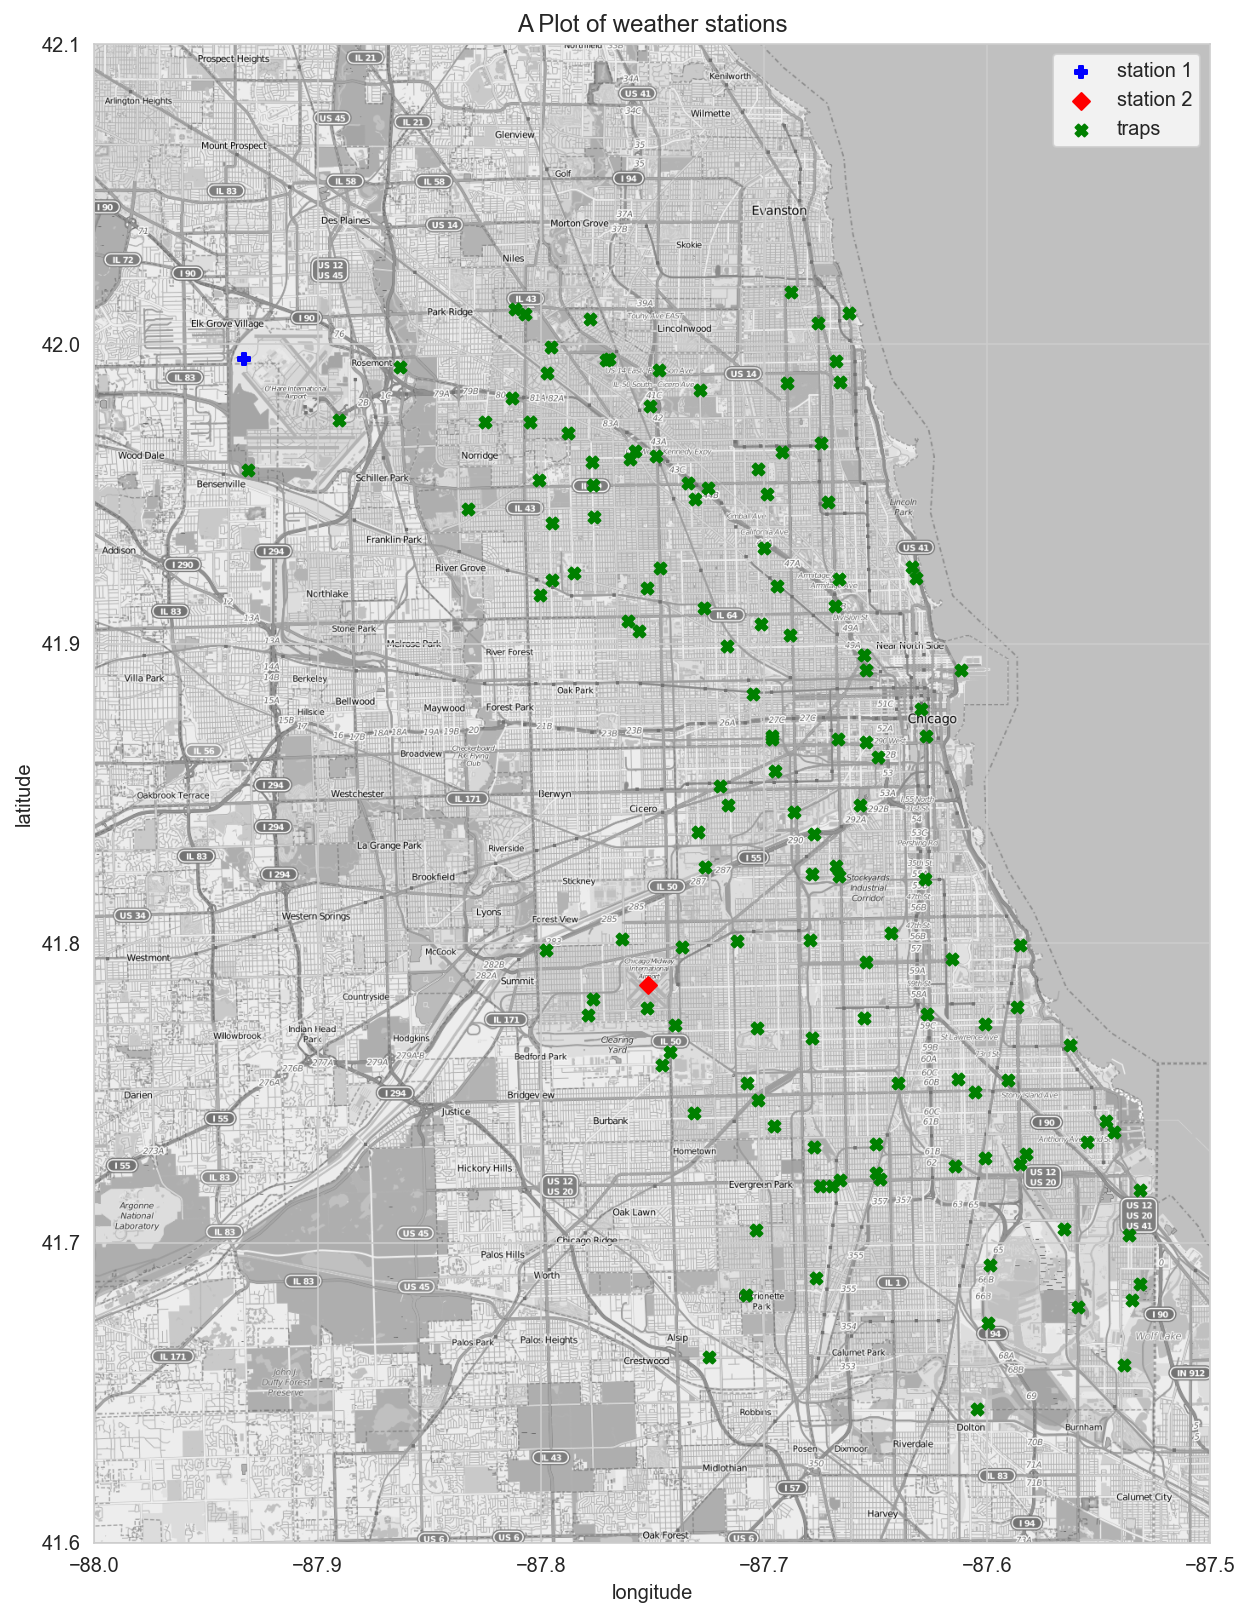

In [38]:
map_data()

In [39]:
display(tn_df1.columns)
display(tt_df1.columns)
display(w_df1.columns)

Index(['Trap', 'Latitude', 'Longitude', 'WnvPresent', 'spp_erraticus',
       'spp_pipiens', 'spp_restuans', 'spp_salinarius', 'spp_tarsalis',
       'spp_territans', 'spp_unspecified'],
      dtype='object')

Index(['Id', 'Trap', 'Latitude', 'Longitude', 'spp_erraticus', 'spp_pipiens',
       'spp_restuans', 'spp_salinarius', 'spp_tarsalis', 'spp_territans',
       'spp_unspecified'],
      dtype='object')

Index(['Station', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Heat', 'Cool', 'Sunrise', 'Sunset', 'Depth', 'Water1', 'SnowFall',
       'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir',
       'AvgSpeed', 'BC', 'BR', 'DZ', 'FG', 'FU', 'GR', 'HZ', 'M', 'MI', 'RA',
       'SN', 'SQ', 'TS', 'VC'],
      dtype='object')

In [40]:
# choose what features to retain in weather data for merging
w_formerge = w_df1.drop(columns=['Depart','Heat','Cool',
                                'Depth','Water1','SnowFall'])
# dropping depart, heat, cool since have collinearity with temperature features
# dropping Depth, Water1 and SnowFall since station 2 is missing that data
# also wish to minimise noise in data
display(w_formerge.head(3))

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,FU,GR,HZ,M,MI,RA,SN,SQ,TS,VC
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,51,56,0448,1849,0.00,29.10,...,0,0,0,1,0,0,0,0,0,0
2007-05-01,2,84,52,68,51,57,-,-,0.00,29.18,...,0,0,0,1,0,0,0,0,0,0
2007-05-02,1,59,42,51,42,47,0447,1850,0.00,29.38,...,0,0,0,0,0,0,0,0,0,0


In [41]:
w_formerge[['Sunrise','Sunset']].head(3)

,Sunrise,Sunset
Date,,
2007-05-01,0448,1849
2007-05-01,-,-
2007-05-02,0447,1850


In [42]:
# use fillna
w_formerge['Sunrise'].replace("-", np.nan, inplace=True)
w_formerge['Sunset'].replace('-', np.nan, inplace=True)
# w_formerge.query("Sunrise.isna()") # To check
w_formerge['Sunrise'].fillna(method='ffill', inplace=True)
w_formerge['Sunset'].fillna(method='ffill', inplace=True)
# w_formerge.query("Tavg.isna()") $ To check

In [43]:
w_formerge.head(3)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,FU,GR,HZ,M,MI,RA,SN,SQ,TS,VC
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,51,56,0448,1849,0.00,29.10,...,0,0,0,1,0,0,0,0,0,0
2007-05-01,2,84,52,68,51,57,0448,1849,0.00,29.18,...,0,0,0,1,0,0,0,0,0,0
2007-05-02,1,59,42,51,42,47,0447,1850,0.00,29.38,...,0,0,0,0,0,0,0,0,0,0


In [44]:
# now to split weather data by station
w1_formerge = w_formerge.loc[w_formerge['Station']==1,:]
display(w1_formerge.head(3))
display(w1_formerge.shape)
w2_formerge = w_formerge.loc[w_formerge['Station']==2,:]
display(w2_formerge.head(3))
display(w2_formerge.shape)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,FU,GR,HZ,M,MI,RA,SN,SQ,TS,VC
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,1,83,50,67,51,56,0448,1849,0.00,29.10,...,0,0,0,1,0,0,0,0,0,0
2007-05-02,1,59,42,51,42,47,0447,1850,0.00,29.38,...,0,0,0,0,0,0,0,0,0,0
2007-05-03,1,66,46,56,40,48,0446,1851,0.00,29.39,...,0,0,0,1,0,0,0,0,0,0


(1472, 28)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,FU,GR,HZ,M,MI,RA,SN,SQ,TS,VC
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-01,2,84,52,68,51,57,0448,1849,0.00,29.18,...,0,0,0,1,0,0,0,0,0,0
2007-05-02,2,60,43,52,42,47,0447,1850,0.00,29.44,...,0,0,1,0,0,0,0,0,0,0
2007-05-03,2,67,48,58,40,50,0446,1851,0.00,29.46,...,0,0,1,0,0,0,0,0,0,0


(1472, 28)

In [45]:
# split train data based on coordinates
# for station 1
t1_formerge = tn_df1.loc[(tn_df1['Latitude']>=41.9) & (tn_df1['Latitude']<=42.05) 
                        & (tn_df1['Longitude']>=-88.0) & (tn_df1['Longitude']<=-87.6),
                             :]
display(t1_formerge.head(3))
display(t1_formerge.shape)
# for station 2
t2_formerge = tn_df1.loc[(tn_df1['Latitude']>=41.6) & (tn_df1['Latitude']<41.9) 
                        & (tn_df1['Longitude']>=-87.9) & (tn_df1['Longitude']<=-87.5),
                             :]
display(t2_formerge.head(3))
display(t2_formerge.shape)
display(tn_df1.shape)
# check no overlap traps
4223 + 6283 # no overlap

,Trap,Latitude,Longitude,WnvPresent,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
Date,,,,,,,,,,,
2007-05-29,T002,41.954690,-87.800991,0,0,1,1,0,0,0,0
2007-05-29,T002,41.954690,-87.800991,0,0,0,1,0,0,0,0
2007-05-29,T007,41.994991,-87.769279,0,0,0,1,0,0,0,0


(4223, 11)

,Trap,Latitude,Longitude,WnvPresent,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
Date,,,,,,,,,,,
2007-05-29,T046,41.891118,-87.654491,0,0,0,1,0,0,0,0
2007-05-29,T048,41.867108,-87.654224,0,0,1,1,0,0,0,0
2007-05-29,T048,41.867108,-87.654224,0,0,0,1,0,0,0,0


(6283, 11)

(10506, 11)

10506

In [46]:
# do the same for test

# split train data based on coordinates
# for station 1
tt1_formerge = tt_df1.loc[(tt_df1['Latitude']>=41.9) & (tt_df1['Latitude']<=42.05) 
                            & (tt_df1['Longitude']>=-88.0) & (tt_df1['Longitude']<=-87.6),
                             :]
display(tt1_formerge.head(3))
display(tt1_formerge.shape)
# for station 2
tt2_formerge = tt_df1.loc[(tt_df1['Latitude']>=41.6) & (tt_df1['Latitude']<41.9) 
                            & (tt_df1['Longitude']>=-87.9) & (tt_df1['Longitude']<=-87.5),
                             :]
display(tt2_formerge.head(3))
display(tt2_formerge.shape)
display(tt_df1.shape)
# check no overlap traps
48374 + 67919 # no overlap, all traps accounted for

,Id,Trap,Latitude,Longitude,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
Date,,,,,,,,,,,
2008-06-11,1,T002,41.95469,-87.800991,0,1,1,0,0,0,0
2008-06-11,2,T002,41.95469,-87.800991,0,0,1,0,0,0,0
2008-06-11,3,T002,41.95469,-87.800991,0,1,0,0,0,0,0


(48374, 11)

,Id,Trap,Latitude,Longitude,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
Date,,,,,,,,,,,
2008-06-11,33,T046,41.891118,-87.654491,0,1,1,0,0,0,0
2008-06-11,34,T046,41.891118,-87.654491,0,0,1,0,0,0,0
2008-06-11,35,T046,41.891118,-87.654491,0,1,0,0,0,0,0


(67919, 11)

(116293, 11)

116293

In [47]:
# join weather with train
# combine by station
# merge by station 1
tn_station1 = pd.merge(right=t1_formerge,
                       left=w1_formerge,
                       how='right', # since train data has narrower date range
                       right_index=True,
                       left_index=True)
display(tn_station1.head(3))
display(tn_station1.shape) # didnt lose any rows after merge

# merge by station 2
tn_station2 = pd.merge(right=t2_formerge,
                       left=w2_formerge, 
                       how='right',
                       right_index=True,
                       left_index=True)
display(tn_station2.head(3))
display(tn_station2.shape) # didnt lose any rows after merge

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,Latitude,Longitude,WnvPresent,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,1,88,60,74,58,65,0421,1917,0.00,29.39,...,41.954690,-87.800991,0,0,1,1,0,0,0,0
2007-05-29,1,88,60,74,58,65,0421,1917,0.00,29.39,...,41.954690,-87.800991,0,0,0,1,0,0,0,0
2007-05-29,1,88,60,74,58,65,0421,1917,0.00,29.39,...,41.994991,-87.769279,0,0,0,1,0,0,0,0


(4223, 39)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,Latitude,Longitude,WnvPresent,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,2,88,65,77,59,66,0421,1917,0.00,29.44,...,41.891118,-87.654491,0,0,0,1,0,0,0,0
2007-05-29,2,88,65,77,59,66,0421,1917,0.00,29.44,...,41.867108,-87.654224,0,0,1,1,0,0,0,0
2007-05-29,2,88,65,77,59,66,0421,1917,0.00,29.44,...,41.867108,-87.654224,0,0,0,1,0,0,0,0


(6283, 39)

In [48]:
# join weather with test
# combine by station
# merge by station 1
tt_station1 = pd.merge(right=tt1_formerge,
                       left=w1_formerge,
                       how='right', # since test data has narrower date range
                       right_index=True,
                       left_index=True)
display(tt_station1.head(3))
display(tt_station1.shape) # didnt lose any rows after merge

# merge by station 2
tt_station2 = pd.merge(right=tt2_formerge,
                       left=w2_formerge, 
                       how='right',
                       right_index=True,
                       left_index=True)
display(tt_station2.head(3))
display(tt_station2.shape) # didnt lose any rows after merge

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,Trap,Latitude,Longitude,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-11,1,86,61,74,56,64,0416,1926,0.00,29.28,...,T002,41.95469,-87.800991,0,1,1,0,0,0,0
2008-06-11,1,86,61,74,56,64,0416,1926,0.00,29.28,...,T002,41.95469,-87.800991,0,0,1,0,0,0,0
2008-06-11,1,86,61,74,56,64,0416,1926,0.00,29.28,...,T002,41.95469,-87.800991,0,1,0,0,0,0,0


(48374, 39)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,Trap,Latitude,Longitude,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-11,2,86,66,76,55,64,0416,1926,0.00,29.34,...,T046,41.891118,-87.654491,0,1,1,0,0,0,0
2008-06-11,2,86,66,76,55,64,0416,1926,0.00,29.34,...,T046,41.891118,-87.654491,0,0,1,0,0,0,0
2008-06-11,2,86,66,76,55,64,0416,1926,0.00,29.34,...,T046,41.891118,-87.654491,0,1,0,0,0,0,0


(67919, 39)

In [49]:
# concat back the 2 stations for train set
wtn_df = pd.concat([tn_station1,tn_station2], axis=0)
# sort index by date
wtn_df.sort_index(inplace=True)
display(wtn_df.shape)
display(wtn_df.head(3))

(10506, 39)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,Latitude,Longitude,WnvPresent,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,1,88,60,74,58,65,0421,1917,0.00,29.39,...,41.954690,-87.800991,0,0,1,1,0,0,0,0
2007-05-29,2,88,65,77,59,66,0421,1917,0.00,29.44,...,41.867108,-87.654224,0,0,0,1,0,0,0,0
2007-05-29,2,88,65,77,59,66,0421,1917,0.00,29.44,...,41.896282,-87.655232,0,0,0,1,0,0,0,0


In [50]:
# concat back the 2 stations for test set
# concat back the 2 stations for train set
wtt_df = pd.concat([tt_station1,tt_station2], axis=0)
# sort index by date
wtt_df.sort_index(inplace=True)
display(wtt_df.shape)
display(wtt_df.head(3))

(116293, 39)

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,Trap,Latitude,Longitude,spp_erraticus,spp_pipiens,spp_restuans,spp_salinarius,spp_tarsalis,spp_territans,spp_unspecified
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-11,1,86,61,74,56,64,0416,1926,0.00,29.28,...,T002,41.954690,-87.800991,0,1,1,0,0,0,0
2008-06-11,2,86,66,76,55,64,0416,1926,0.00,29.34,...,T209,41.740641,-87.546587,0,0,0,0,0,0,1
2008-06-11,2,86,66,76,55,64,0416,1926,0.00,29.34,...,T209,41.740641,-87.546587,1,0,0,0,0,0,0


---
## Drop features not included in test set

In [51]:
# compare features in train and test set
display(wtn_df.columns)
display(wtt_df.columns)

Index(['Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Sunrise',
       'Sunset', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'BC', 'BR', 'DZ', 'FG', 'FU', 'GR', 'HZ', 'M',
       'MI', 'RA', 'SN', 'SQ', 'TS', 'VC', 'Trap', 'Latitude', 'Longitude',
       'WnvPresent', 'spp_erraticus', 'spp_pipiens', 'spp_restuans',
       'spp_salinarius', 'spp_tarsalis', 'spp_territans', 'spp_unspecified'],
      dtype='object')

Index(['Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Sunrise',
       'Sunset', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed', 'BC', 'BR', 'DZ', 'FG', 'FU', 'GR', 'HZ', 'M',
       'MI', 'RA', 'SN', 'SQ', 'TS', 'VC', 'Id', 'Trap', 'Latitude',
       'Longitude', 'spp_erraticus', 'spp_pipiens', 'spp_restuans',
       'spp_salinarius', 'spp_tarsalis', 'spp_territans', 'spp_unspecified'],
      dtype='object')

In [52]:
# check dtypes that are not int64 or float64
display(list(wtn_df.select_dtypes(exclude=['int64','float64'])))
display(list(wtt_df.select_dtypes(exclude=['int64','float64'])))

['Tavg',
 'WetBulb',
 'Sunrise',
 'Sunset',
 'PrecipTotal',
 'StnPressure',
 'SeaLevel',
 'AvgSpeed',
 'Trap']

['Tavg',
 'WetBulb',
 'Sunrise',
 'Sunset',
 'PrecipTotal',
 'StnPressure',
 'SeaLevel',
 'AvgSpeed',
 'Trap']

#### Tavg

In [53]:
# convert Tavg to numeric
wtn_df['Tavg'].value_counts() # checking if any string values are obstructing dtype conversion

77    946
80    878
72    736
79    610
71    608
76    593
73    568
75    518
78    482
81    474
82    464
70    453
74    423
64    374
65    292
67    211
56    189
61    178
66    173
69    141
84    127
63    123
60    115
86    109
55    109
54    105
83    104
52    103
62     68
57     64
51     38
68     34
50     26
87     25
53     23
58     22
Name: Tavg, dtype: int64

In [54]:
# check the same in test set
wtt_df['Tavg'].value_counts() # checking if any string values are obstructing dtype conversion

73    9103
77    8168
69    7698
75    7559
71    7351
68    6707
79    6682
66    6583
78    6529
76    5909
70    4591
72    4401
64    4145
80    4104
83    3920
82    3494
74    3148
67    2438
59    2254
62    2224
63    1936
61    1712
84    1439
60    1424
65    1047
55     712
53     510
58     505
Name: Tavg, dtype: int64

#### WetBulb

In [55]:
# convert WetBulb to numeric
wtn_df['WetBulb'].value_counts() # there are 'M' values in 'WetBulb' feature

70    901
69    892
62    825
71    745
65    589
72    524
64    510
67    471
68    467
63    446
61    389
59    366
74    342
57    342
58    339
66    329
60    269
75    244
76    184
47    181
73    165
49    160
51    148
54    136
56    134
50    130
52    101
55     93
M      44
53     26
46     14
Name: WetBulb, dtype: int64

In [56]:
wtn_df.loc[wtn_df['WetBulb']=='M',['WetBulb','StnPressure']] 
# all 'M' values in wetbulb are associated with StnPressure 'M' values
# this is great, can drop these rows from StnPressure without additional data points lost

,WetBulb,StnPressure
Date,,
2009-06-26,M,M
2009-06-26,M,M
2009-06-26,M,M
2009-06-26,M,M
2009-06-26,M,M
2009-06-26,M,M
2009-06-26,M,M
2009-06-26,M,M
2009-06-26,M,M


In [57]:
wtt_df.loc[wtt_df['WetBulb']=='M',['WetBulb']] # good no missing data in wetbulb test data

,WetBulb
Date,


#### StnPressure

In [58]:
# convert StnPressure dtype
display(len(wtn_df.loc[wtn_df['StnPressure']=='M', ['StnPressure']])) # 44 missing values
# drop StnPressure values = 'M'
wtn_df = wtn_df[wtn_df['StnPressure'] != 'M']

44

In [59]:
# do the same for test
display(len(wtt_df.loc[wtt_df['StnPressure']=='M', ['StnPressure']])) 
# that is good, coz cannot drop any test rows, need for Kaggle submission

0

#### SeaLevel

In [60]:
# convert SeaLevel to numeric
display(len(wtn_df.loc[wtn_df['SeaLevel']=='M', ['SeaLevel']])) # no missing values

0

In [61]:
# check the same for test set
display(len(wtt_df.loc[wtt_df['SeaLevel']=='M', ['SeaLevel']])) # no missing values

0

#### AvgSpeed

In [62]:
# convert AvgSpeed to numeric
# first, need to find out if any 'M' values in AvgSpeed since it was classified object dtype 
# by pandas
len(wtn_df.loc[wtn_df['AvgSpeed']=='M', ['AvgSpeed']])  # there is none

0

In [63]:
# find out the same for test set
len(wtt_df.loc[wtt_df['AvgSpeed']=='M', ['AvgSpeed']])  # there is none

0

In [64]:
# convert dtypes
wtn_df['StnPressure'] = wtn_df['StnPressure'].astype('float64')
wtn_df['SeaLevel'] = wtn_df['SeaLevel'].astype('float64')
wtn_df['WetBulb'] = wtn_df['WetBulb'].astype('int64')
wtn_df['AvgSpeed'] = wtn_df['AvgSpeed'].astype('float64')
wtn_df['Tavg'] = wtn_df['Tavg'].astype('int64')
wtn_df['Sunrise'] = wtn_df['Sunrise'].astype('int64')
wtn_df['Sunset'] = wtn_df['Sunset'].astype('int64')

In [65]:
# do the same for test
wtt_df['StnPressure'] = wtt_df['StnPressure'].astype('float64')
wtt_df['SeaLevel'] = wtt_df['SeaLevel'].astype('float64')
wtt_df['WetBulb'] = wtt_df['WetBulb'].astype('int64')
wtt_df['AvgSpeed'] = wtt_df['AvgSpeed'].astype('float64')
wtt_df['Tavg'] = wtt_df['Tavg'].astype('int64')
wtt_df['Sunrise'] = wtt_df['Sunrise'].astype('int64')
wtt_df['Sunset'] = wtt_df['Sunset'].astype('int64')

#### PrecipTotal

In [66]:
wtn_df['PrecipTotal'].value_counts() # there are 'T' and 'M' values

0.00    5905
  T      879
0.01     272
0.23     251
0.06     235
0.09     181
0.83     172
0.36     163
0.16     158
0.02     146
0.88     137
0.84     117
0.03     115
0.20     115
0.92     106
0.08      96
0.12      82
1.31      80
0.13      74
0.58      73
0.17      72
0.39      72
0.24      71
0.70      70
0.11      67
0.59      63
1.55      61
0.33      56
0.14      55
0.50      53
0.87      52
0.79      49
0.52      44
3.97      41
0.19      38
0.42      36
0.04      34
1.19      30
0.89      26
0.95      24
0.27      24
0.46      23
M         21
0.44      18
0.05       3
0.37       2
Name: PrecipTotal, dtype: int64

In [67]:
# convert PrecipTotal to numeric
# replace T with 0.00
# remove rows with missing data 'M'
# convert to float
wtn_df.loc[wtn_df['PrecipTotal']=='  T', ['PrecipTotal']]= 0.00
wtn_df = wtn_df[wtn_df['PrecipTotal'] != 'M']
wtn_df['PrecipTotal'] = wtn_df['PrecipTotal'].astype('float64')

In [68]:
# do the same for test
wtt_df['PrecipTotal'].value_counts() # only T are non-numeric values in test PrecipTotal

0.00    66558
  T      8775
0.01     4632
0.03     3695
0.02     3170
0.13     1920
0.05     1725
0.66     1427
0.28     1256
0.39     1225
0.08     1222
0.32     1011
1.29      724
0.43      719
3.15      717
0.40      715
0.11      713
0.23      713
0.89      712
0.92      712
0.20      712
0.31      712
0.72      712
0.59      712
0.41      712
1.30      712
0.80      548
0.98      529
0.42      519
0.17      517
0.18      516
0.19      512
0.07      512
0.50      510
0.25      509
1.55      505
2.79      505
0.82      503
0.06      503
0.26      502
2.43      501
1.02      500
0.87      497
0.34      496
0.16      496
Name: PrecipTotal, dtype: int64

In [69]:
# convert dtype in test set for PrecipTotal
wtt_df.loc[wtt_df['PrecipTotal']=='  T', ['PrecipTotal']]= 0.00
wtt_df['PrecipTotal'] = wtt_df['PrecipTotal'].astype('float64')

In [70]:
# check dtype remaining
# check dtypes that are not int64 or float64
display(list(wtn_df.select_dtypes(exclude=['int64','float64'])))
display(list(wtt_df.select_dtypes(exclude=['int64','float64'])))

['Trap']

['Trap']

#### Trap

In [71]:
# vectorize Trap
display(len(wtn_df['Trap'].value_counts())) # 136
display(len(wtt_df['Trap'].value_counts())) # 149 values in test

136

149

In [72]:
# find out what traps are in test but not in train
tn_trap = set(wtn_df['Trap'].values)
tt_trap = set(wtt_df['Trap'].values)
print(tn_trap.difference(tt_trap))
print(tt_trap.difference(tn_trap))
print(len(tt_trap.difference(tn_trap)))

set()
{'T090B', 'T200A', 'T218A', 'T002A', 'T200B', 'T218B', 'T218C', 'T234', 'T090C', 'T128A', 'T002B', 'T065A', 'T090A'}
13


In [73]:
display(wtn_df.shape)
display(wtt_df.shape)

(10441, 39)

(116293, 39)

In [74]:
print(wtn_df['Trap'].isnull().sum())
print(wtt_df['Trap'].isnull().sum())

0
0


In [75]:
wtn_df1 = pd.get_dummies(data=wtn_df, columns=['Trap'], prefix='', prefix_sep='', dtype='int64')
wtn_df1 = wtn_df1.assign(**{'T200B': 0, 'T218C':0, 'T090A':0, 'T218A':0, 'T218B':0,
              'T065A':0, 'T002A':0, 'T200A':0, 'T002B':0, 'T090C':0,
              'T090B':0, 'T234':0, 'T128A':0}) # add the missing traps in train set to match test
wtn_df1.shape

(10441, 187)

In [76]:
wtt_df1 = pd.get_dummies(data=wtt_df, columns=['Trap'], prefix='', prefix_sep='', dtype='int64')
wtt_df1.shape

(116293, 187)

In [77]:
# check dtype remaining
# check dtypes that are not int64 or float64
display(list(wtn_df1.select_dtypes(exclude=['int64','float64'])))
display(list(wtt_df1.select_dtypes(exclude=['int64','float64'])))

[]

[]

## [`spray.csv`](./assets/input/spray.csv)

In [78]:
s_df = pd.read_csv('./assets/input/spray.csv', parse_dates=[0], infer_datetime_format=True)
s_df.head(3)

,Date,Time,Latitude,Longitude
0,2011-08-29,6:56:58 PM,42.391623,-88.089163
1,2011-08-29,6:57:08 PM,42.391348,-88.089163
2,2011-08-29,6:57:18 PM,42.391022,-88.089157


In [79]:
s_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14835 entries, 0 to 14834
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       14835 non-null  datetime64[ns]
 1   Time       14251 non-null  object        
 2   Latitude   14835 non-null  float64       
 3   Longitude  14835 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 463.7+ KB


In [80]:
# drop Time since not going to use that in machine learning
s_df.drop(columns=['Time'],inplace=True)

In [81]:
# set datetime as index 
s_df.set_index('Date', inplace=True)

In [82]:
s_df.sort_index(inplace=True) # just in case not sorted by date already

In [83]:
s_df.head(3) # check

,Latitude,Longitude
Date,,
2011-08-29,42.391623,-88.089163
2011-08-29,42.391348,-88.089163
2011-08-29,42.391022,-88.089157


In [84]:
# plot comparison of spray locations vs. trap locations
# function to plot data on map
def spray_map():
    mapdata = np.loadtxt("./assets/input/mapdata_copyright_openstreetmap_contributors.txt")
    all_sprays = s_df[['Longitude','Latitude']]
    all_traps = wtn_df[['Trap','Longitude', 'Latitude', 'WnvPresent']]

    # set up base map
    aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
    lon_lat_box = (-88.0, -87.5, 41.6, 42.1)

    plt.figure(figsize=(10,14))
    plt.imshow(mapdata, 
               cmap=plt.get_cmap('gray'), 
               extent=lon_lat_box, 
               aspect=aspect)
 
    # plot base data
    all_locations1 = all_sprays[['Longitude', 'Latitude']].drop_duplicates().values
    all_locations2 = all_traps[['Longitude', 'Latitude']].drop_duplicates().values
    plt.scatter(all_locations1[:,0], all_locations1[:,1], marker='P', color='steelblue')
    plt.scatter(all_locations2[:,0], all_locations2[:,1], marker='D', color='red')
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title('A Plot of spray and trap locations')
    plt.legend(['spray','trap'], loc='upper right');

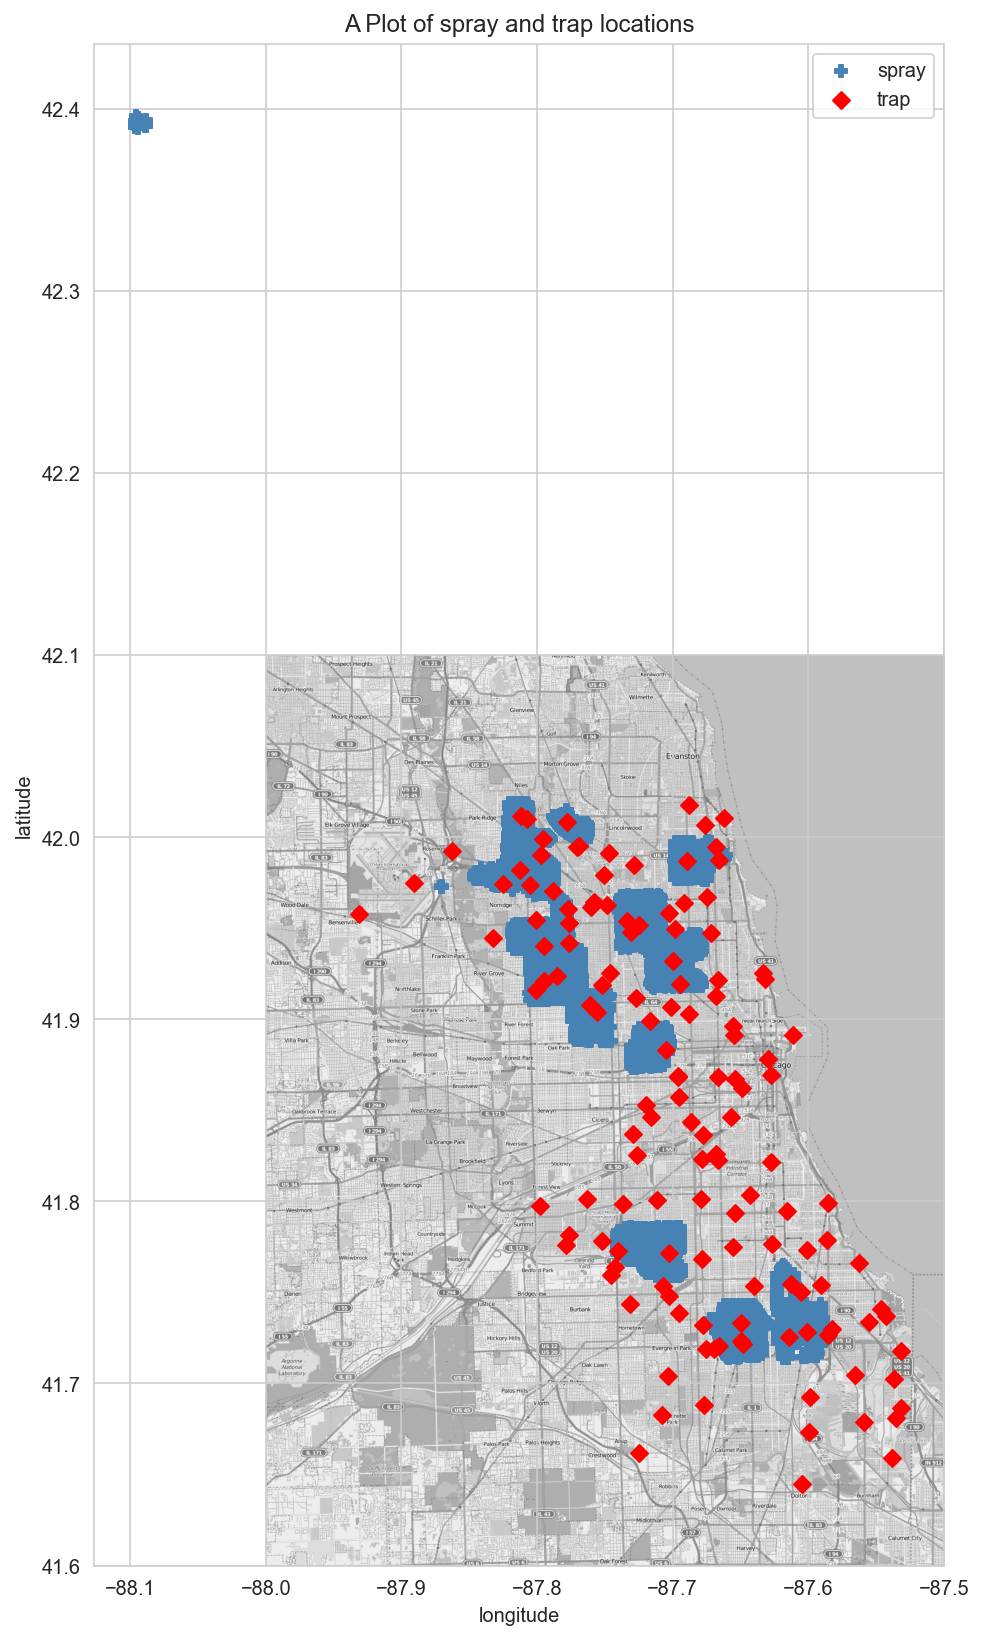

In [85]:
spray_map() # outliers in latitude 42.4 

In [86]:
s_df.index.value_counts().sort_index()

2011-08-29      95
2011-09-07    2114
2013-07-17    2202
2013-07-25    1607
2013-08-08    1195
2013-08-15    2668
2013-08-16     141
2013-08-22    1587
2013-08-29    2302
2013-09-05     924
Name: Date, dtype: int64

In [87]:
# 2011 spray affected dates
# wtn_df1.loc[(wtn_df1['Date']>'2011-09-07')&(wtn_df1['Date']<'2012-01-01'), ['Date']]
# 2013 spray affected dates
#wtn_df1.loc[(wtn_df1['Date']>'2013-07-17')&(wtn_df1['Date']<='2013-09-06'), ['Date']]

In [88]:
# assign new column to wtn_df1
# spray

# create list of conditions
conditions = [(wtn_df1.index >'2011-09-07')&(wtn_df1.index<'2012-01-01') # 2011 sprayed
             &(wtn_df1['Latitude']>=41.95)&(wtn_df1['Latitude']<42.05)
             &(wtn_df1['Longitude']<-87.75)&(wtn_df1['Longitude']>-87.87),
             (wtn_df1.index>'2013-07-17')&(wtn_df1.index<='2013-09-06') # 2013 sprayed
              &((wtn_df1['Latitude']>=41.85)&(wtn_df1['Longitude']<=-87.65)&(wtn_df1['Longitude']>-87.90)|
             (wtn_df1['Latitude']<=41.80)&(wtn_df1['Latitude']>=41.70)), 
             (wtn_df1.index>'2011-09-07')&(wtn_df1.index<'2012-01-01') # 2011 not sprayed
             &((wtn_df1['Longitude']<=-87.87)|(wtn_df1['Longitude']>=-87.75)|
             (wtn_df1['Latitude'])<41.95),
              (wtn_df1.index>'2013-07-17')&(wtn_df1.index<='2013-09-06') # 2013 not sprayed
             & ((wtn_df1['Latitude']<41.85)&(wtn_df1['Latitude']>41.80)|
              (wtn_df1['Latitude']<41.70)|
              (wtn_df1['Longitude']>-87.65)&(wtn_df1['Latitude']>=41.85)|
              (wtn_df1['Longitude']<-87.90))]

values = [1,1,0,0]

# create a new column and use np.select to assign values to it using our lists as arguments
wtn_df1['spray'] = np.select(conditions, values)

wtn_df1[['spray','Latitude','Longitude']].head(3) # check


,spray,Latitude,Longitude
Date,,,
2007-05-29,0,41.954690,-87.800991
2007-05-29,0,41.867108,-87.654224
2007-05-29,0,41.896282,-87.655232


In [89]:
wtn_df1.loc[wtn_df1['spray']==1, ['spray','Latitude','Longitude']] # check

,spray,Latitude,Longitude
Date,,,
2011-09-12,1,42.008314,-87.777921
2011-09-12,1,42.009876,-87.807277
2011-09-12,1,42.009876,-87.807277
2011-09-12,1,42.009876,-87.807277
2011-09-12,1,41.964242,-87.757639
...,...,...,...
2013-09-06,1,41.704336,-87.703736
2013-09-06,1,41.899230,-87.716788
2013-09-06,1,41.891118,-87.654491


In [90]:
# do the same for test 
wtt_df1['spray'] = 0 # no spray data for test dates

---
## One Hot encode `dates`

In [91]:
display(wtn_df1.head(3))
display(wtt_df1.head(3))

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,T218B,T065A,T002A,T200A,T002B,T090C,T090B,T234,T128A,spray
Date,,,,,,,,,,,,,,,,,,,,,
2007-05-29,1,88,60,74,58,65,421,1917,0.0,29.39,...,0,0,0,0,0,0,0,0,0,0
2007-05-29,2,88,65,77,59,66,421,1917,0.0,29.44,...,0,0,0,0,0,0,0,0,0,0
2007-05-29,2,88,65,77,59,66,421,1917,0.0,29.44,...,0,0,0,0,0,0,0,0,0,0


,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,T232,T233,T234,T235,T236,T237,T238,T900,T903,spray
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-11,1,86,61,74,56,64,416,1926,0.0,29.28,...,0,0,0,0,0,0,0,0,0,0
2008-06-11,2,86,66,76,55,64,416,1926,0.0,29.34,...,0,0,0,0,0,0,0,0,0,0
2008-06-11,2,86,66,76,55,64,416,1926,0.0,29.34,...,0,0,0,0,0,0,0,0,0,0


In [92]:
# new column with month and day
wtn_df1 = wtn_df1.reset_index() # shift date index back to column
wtn_df1['Day'] = wtn_df1['Date'].dt.strftime('%d') # extract day
wtn_df1['Month'] = wtn_df1['Date'].dt.strftime('%m') # extract month
wtn_df1['Year'] = wtn_df1['Date'].dt.strftime('%Y') # extract year
wtn_df2 = wtn_df1.drop(columns=['Date']) # drop full date column
# bring Year, Day and month to front
wtn_df2.set_index(['Year','Month','Day'], inplace=True)
wtn_df2 = wtn_df2.reset_index() # shift date index back to column
display(wtn_df2.head(3))

,Year,Month,Day,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,...,T218B,T065A,T002A,T200A,T002B,T090C,T090B,T234,T128A,spray
0,2007,05,29,1,88,60,74,58,65,421,...,0,0,0,0,0,0,0,0,0,0
1,2007,05,29,2,88,65,77,59,66,421,...,0,0,0,0,0,0,0,0,0,0
2,2007,05,29,2,88,65,77,59,66,421,...,0,0,0,0,0,0,0,0,0,0


In [93]:
# convert date values as categories
display(wtn_df2['Year'].value_counts()) # 4 different values
display(wtn_df2['Month'].value_counts())
display(wtn_df2['Day'].value_counts())

2007    3790
2013    2392
2009    2205
2011    2054
Name: Year, dtype: int64

08    3751
07    2606
09    2218
06    1506
10     276
05      84
Name: Month, dtype: int64

01    864
12    815
19    674
25    656
15    642
24    537
17    452
08    393
07    392
05    368
29    362
22    358
02    354
26    317
06    305
21    302
11    298
27    282
04    277
28    239
14    232
18    222
16    213
30    182
13    176
10    155
31    139
23    109
03     74
09     52
Name: Day, dtype: int64

In [94]:
wtn_df3 = pd.get_dummies(data=wtn_df2, columns=['Year','Month','Day'], prefix=['Yr','Mth','Day'], dtype='int64')
wtn_df3.head(3)
#wtn_df3 = wtn_df2.copy()

,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,Sunset,PrecipTotal,StnPressure,...,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31
0,1,88,60,74,58,65,421,1917,0.0,29.39,...,0,0,0,0,0,0,0,1,0,0
1,2,88,65,77,59,66,421,1917,0.0,29.44,...,0,0,0,0,0,0,0,1,0,0
2,2,88,65,77,59,66,421,1917,0.0,29.44,...,0,0,0,0,0,0,0,1,0,0


In [95]:
#wtn_df3.columns[150:]

In [96]:
# do the same for test set
# new column with month and day
wtt_df1 = wtt_df1.reset_index() # shift date index back to column
wtt_df1['Day'] = wtt_df1['Date'].dt.strftime('%d') # extract day
wtt_df1['Month'] = wtt_df1['Date'].dt.strftime('%m') # extract month
wtt_df1['Year'] = wtt_df1['Date'].dt.strftime('%Y') # extract year
wtt_df2 = wtt_df1.drop(columns=['Date']) # drop full date column
# bring Day and month to front
wtt_df2.set_index(['Year','Month','Day'], inplace=True)
wtt_df2 = wtt_df2.reset_index() # shift date index back to column
display(wtt_df2.head(3))

,Year,Month,Day,Station,Tmax,Tmin,Tavg,DewPoint,WetBulb,Sunrise,...,T232,T233,T234,T235,T236,T237,T238,T900,T903,spray
0,2008,06,11,1,86,61,74,56,64,416,...,0,0,0,0,0,0,0,0,0,0
1,2008,06,11,2,86,66,76,55,64,416,...,0,0,0,0,0,0,0,0,0,0
2,2008,06,11,2,86,66,76,55,64,416,...,0,0,0,0,0,0,0,0,0,0


In [97]:
wtt_df3 = pd.get_dummies(data=wtt_df2, columns=['Year','Month','Day'], prefix=['Yr','Mth','Day'], dtype='int64')
wtt_df3.columns[150:]
#wtt_df3 = wtt_df2.copy()

Index(['T159', 'T160', 'T161', 'T162', 'T200', 'T200A', 'T200B', 'T206',
       'T209', 'T212', 'T215', 'T218', 'T218A', 'T218B', 'T218C', 'T219',
       'T220', 'T221', 'T222', 'T223', 'T224', 'T225', 'T226', 'T227', 'T228',
       'T229', 'T230', 'T231', 'T232', 'T233', 'T234', 'T235', 'T236', 'T237',
       'T238', 'T900', 'T903', 'spray', 'Yr_2008', 'Yr_2010', 'Yr_2012',
       'Yr_2014', 'Mth_06', 'Mth_07', 'Mth_08', 'Mth_09', 'Mth_10', 'Day_01',
       'Day_02', 'Day_03', 'Day_04', 'Day_05', 'Day_06', 'Day_07', 'Day_08',
       'Day_09', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14', 'Day_15',
       'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_20', 'Day_21', 'Day_23',
       'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29', 'Day_30',
       'Day_31'],
      dtype='object')

In [98]:
# check dtype remaining
# check dtypes that are not int64 or float64
display(list(wtn_df3.select_dtypes(exclude=['int64','float64'])))
display(list(wtt_df3.select_dtypes(exclude=['int64','float64'])))

['spray']

[]

In [99]:
# reassign dtype
wtn_df3 = wtn_df3.astype({'spray':'int64'})



In [100]:
# check dtype remaining
# check dtypes that are not int64 or float64
display(list(wtn_df3.select_dtypes(exclude=['int64','float64'])))
display(list(wtt_df3.select_dtypes(exclude=['int64','float64'])))

[]

[]

In [101]:
display(wtn_df3.shape)
display(wtt_df3.shape)

(10441, 228)

(116293, 227)

In [102]:
# find out the columns that are not common between both datasets
tn_cols = set(wtn_df3.columns.tolist())
tt_cols = set(wtt_df3.columns.tolist())
print(tn_cols.difference(tt_cols))
print(tt_cols.difference(tn_cols))
print(len(tt_cols.difference(tn_cols)))

{'WnvPresent', 'Yr_2009', 'Mth_05', 'Yr_2013', 'Yr_2007', 'Yr_2011', 'Day_22'}
{'Yr_2008', 'Yr_2010', 'Id', 'Yr_2012', 'Day_20', 'Yr_2014'}
6


In [103]:
# add new columns to both train and test datasets to make sure features are consistent
wtn_df3 = wtn_df3.assign(**{'Yr_2008': 0, 'Yr_2010':0, 'Yr_2012':0, 
                            'Yr_2014':0, 'Day_20':0
                            }) 
wtt_df3 = wtt_df3.assign(**{'Yr_2007':0, 'Yr_2009':0, 'Yr_2011':0,
                           'Yr_2013':0, 'Mth_05':0, 'Day_22':0})

In [104]:
# find out the columns that are not common between both datasets
# check again
tn_cols = set(wtn_df3.columns.tolist())
tt_cols = set(wtt_df3.columns.tolist())
print(tn_cols.difference(tt_cols))
print(tt_cols.difference(tn_cols))

{'WnvPresent'}
{'Id'}


In [105]:
# check shape
display(wtn_df3.shape)
display(wtt_df3.shape)

(10441, 233)

(116293, 233)

## Export

In [106]:
wtn_df3.to_csv('./datasets/train.csv', index=False)
wtt_df3.to_csv('./datasets/test.csv', index=False)

In [107]:
# another copy
wtt_df4 = wtt_df3.copy()
# reassign value
wtt_df4['spray'] = 1 # simulate if all trap sites were sprayed

In [108]:
display(wtt_df4.shape)
display(wtt_df4[['spray']].head(3))

(116293, 233)

,spray
0,1
1,1
2,1


In [109]:
wtt_df4.to_csv('./datasets/test_sprayed.csv', index=False)

In [110]:
# submission file contains just id and wnvpresent
# model cannot be fed features present in train but not present in test data

---

## 2.2 Feature Engineering

In [111]:
df_train = pd.read_csv('./datasets/train.csv')
df_test = pd.read_csv('./datasets/test.csv')
print(df_train.shape)
print(df_test.shape)

(10441, 233)
(116293, 233)


In [112]:
df_test.columns

Index(['Station', 'Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Sunrise',
       'Sunset', 'PrecipTotal', 'StnPressure',
       ...
       'Day_28', 'Day_29', 'Day_30', 'Day_31', 'Yr_2007', 'Yr_2009', 'Yr_2011',
       'Yr_2013', 'Mth_05', 'Day_22'],
      dtype='object', length=233)

In [113]:
#data imbalaance
df_train['WnvPresent'].value_counts()

0    9890
1     551
Name: WnvPresent, dtype: int64

As we can see, there is around 10:0.5 of  `data imbalance` in the dataset. To deal with it, we decided to use SMOTE method to oversample the training set to make a robust prediction model.

In [114]:
# Define predictor and target variables of training set 

X= df_train.drop(columns=['WnvPresent'])
feature = X.columns      # save feature names for later use
y= df_train['WnvPresent']
print(y.shape)
print(X.shape)

(10441,)
(10441, 232)


In [115]:
#preserve the Id sequence for submission later
id = df_test[['Id']]
df_test = df_test.drop(columns=['Id'])

In [116]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(8352, 232) (8352,)
(2089, 232) (2089,)


In [117]:
neg, pos = np.bincount(y_train)
total = neg + pos
print('Train set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Train set:
    Total: 8352
    Positive: 441 (5.28% of total)



In [118]:
neg_t, pos_t = np.bincount(y_test)
total_t = neg_t + pos_t
print('Test set:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total_t, pos_t, 100 * pos_t / total_t))

Test set:
    Total: 2089
    Positive: 110 (5.27% of total)



#### With setting `'stratify = y'` in train test split, we can get the same proportion of data in train and test set

In [119]:
## MinMaxScaler to scale the data

mmm = MinMaxScaler()
X_train_scaled = mmm.fit_transform(X_train)
X_val_scaled = mmm.transform(X_test)    #validation set
X_test_scaled = mmm.transform(df_test)  #for submission to kaggle

c:\Users\pkfei\anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


### Visualize the data using 2 PCA components
```
The effect of SMOTE to oversample our train dataset are clearly shows on the PCA plot
```

(8352, 2)
(8352,)


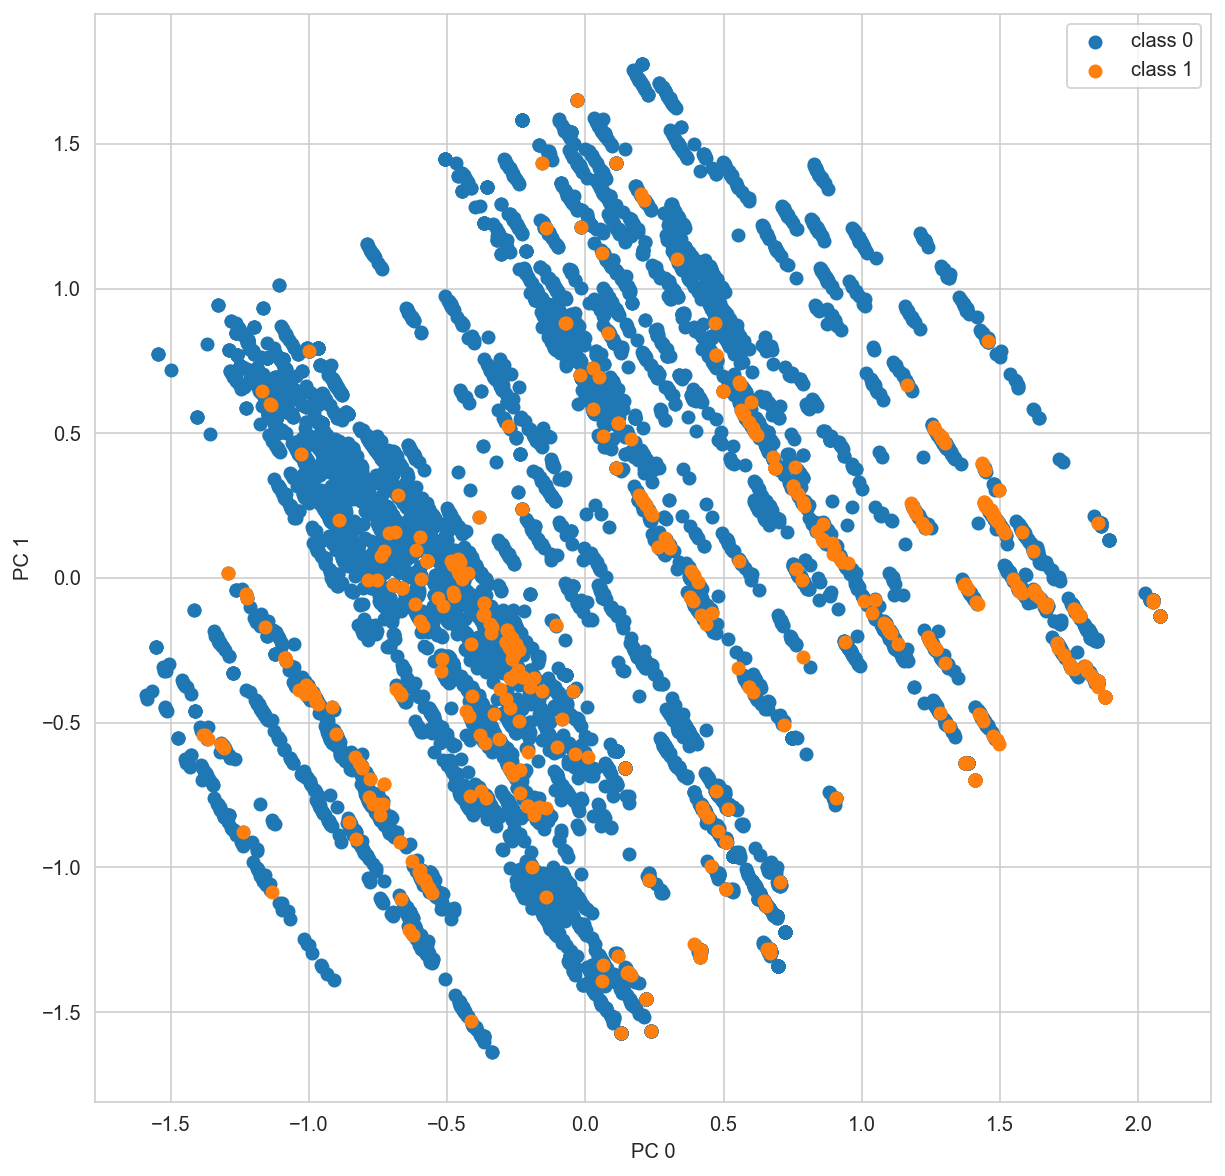

In [120]:
## PCA component before SMOTE

PCA1 = PCA(n_components=2)
PCA1.fit(X_train_scaled)
X_train_PCA1 = PCA1.transform(X_train_scaled)

print(X_train_PCA1.shape)
print(y_train.shape)

fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(X_train_PCA1[(y_train==0),0],X_train_PCA1[(y_train==0),1],label = 'class 0')
ax.scatter(X_train_PCA1[(y_train==1),0],X_train_PCA1[(y_train==1),1],label = 'class 1')

ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.legend()
plt.show()

In [121]:
# Use smote to deal with imbalance data
from imblearn.over_sampling import SMOTE
import imblearn

sm = SMOTE(random_state=42)
X_train_scaled_sm,y_train_sm = sm.fit_resample(X_train_scaled,y_train)
print(X_train_scaled_sm.shape, y_train_sm.shape)

(15822, 232) (15822,)


(15822, 2)
(15822,)


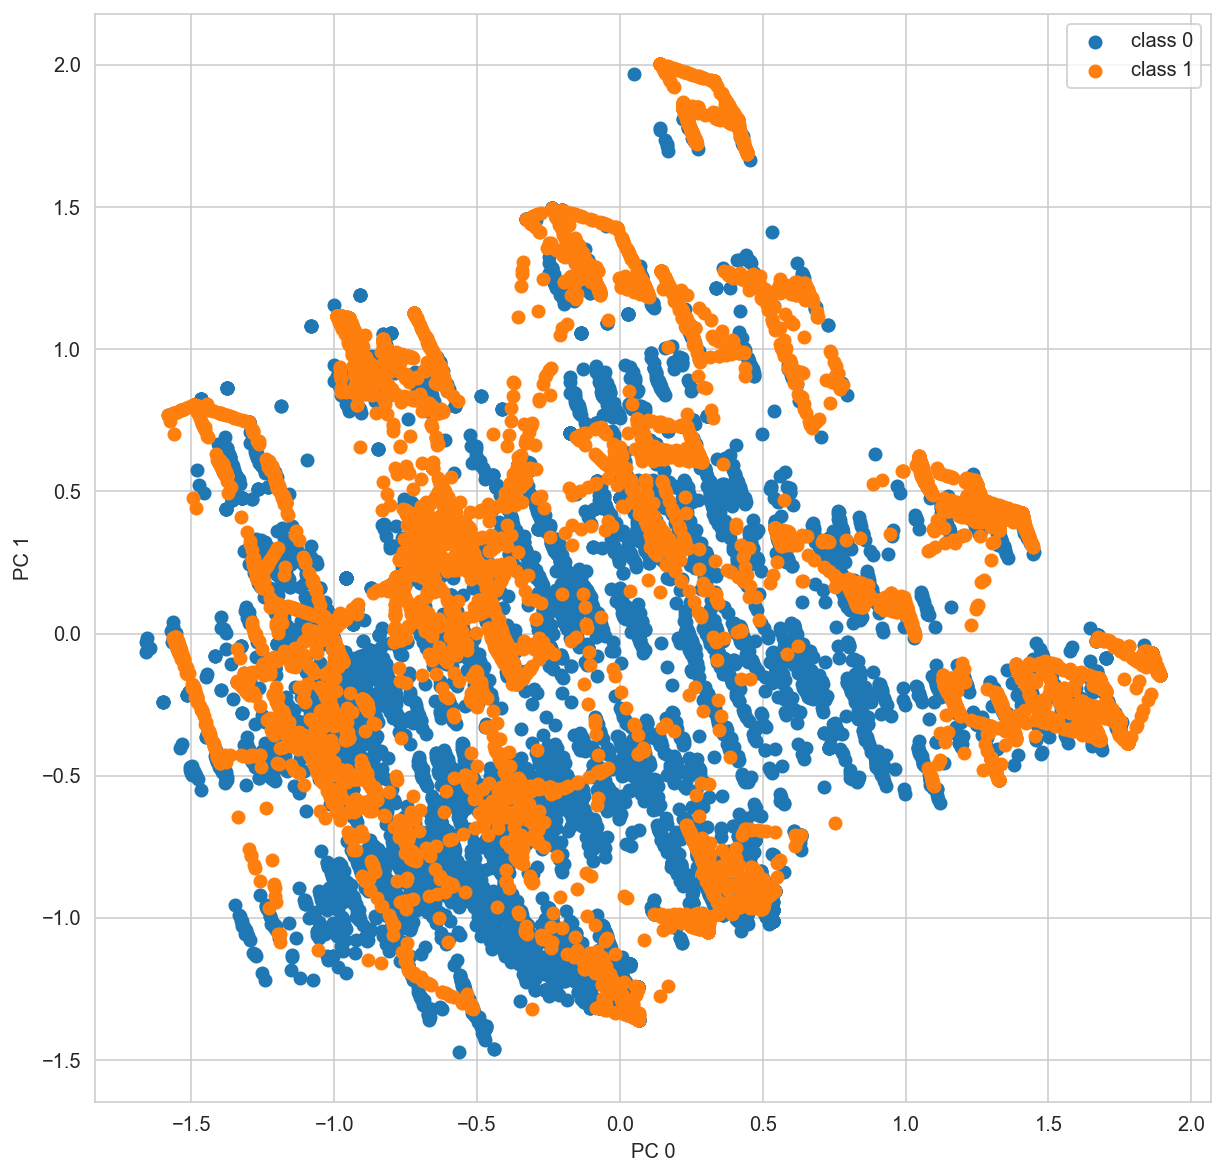

In [122]:
## PCA component after SMOTE
PCA2 = PCA(n_components=2)
PCA2.fit(X_train_scaled_sm)
X_train_PCA2 = PCA2.transform(X_train_scaled_sm)

print(X_train_PCA2.shape)
print(y_train_sm.shape)

fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(X_train_PCA2[(y_train_sm==0),0],X_train_PCA2[(y_train_sm==0),1],label = 'class 0')
ax.scatter(X_train_PCA2[(y_train_sm==1),0],X_train_PCA2[(y_train_sm==1),1],label = 'class 1')

ax.set_xlabel('PC 0')
ax.set_ylabel('PC 1')
ax.legend()
plt.show()

### The final part of this section is output the processed dataset to be used in our modeeling steps

In [123]:
#reassign the variable name
Z_train = X_train_scaled_sm  #after smote
y_train = y_train_sm    

Z_test= X_val_scaled        #validation set
y_test = y_test             #validation set

test_data = X_test_scaled   #kaggle submission set


# save the data
with open('./datasets/Z_train.pickle', 'wb') as to_write:
    pickle.dump(Z_train, to_write)
with open('./datasets/y_train.pickle', 'wb') as to_write:
    pickle.dump(y_train, to_write)

with open('./datasets/Z_test.pickle', 'wb') as to_write:
    pickle.dump(Z_test, to_write)

with open('./datasets/y_test.pickle', 'wb') as to_write:
    pickle.dump(y_test, to_write)

with open('./datasets/test_data.pickle', 'wb') as to_write:
    pickle.dump(test_data, to_write)

with open('./datasets/id.pickle', 'wb') as to_write:
    pickle.dump(id, to_write)

with open('./datasets/feature.pickle', 'wb') as to_write:
    pickle.dump(feature, to_write)

print(f'train data shape: {Z_train.shape}, {y_train.shape}')
print(f'test data shape: {Z_test.shape}, {y_test.shape}')

train data shape: (15822, 232), (15822,)
test data shape: (2089, 232), (2089,)
